In [58]:
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from collections import Counter
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [59]:
df = pd.read_csv('spam.csv', encoding='latin-1')
encoder = LabelEncoder()
ps = PorterStemmer()

In [60]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [61]:
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

In [62]:
df['target'] = encoder.fit_transform(df['target'])

In [63]:
df = df.drop_duplicates(keep='first')

In [64]:
nltk.download('punkt') 
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hardikmittal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hardikmittal/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hardikmittal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
df['num_char'] = df['text'].apply(len)

In [66]:
# num of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [67]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [68]:
df[['num_char', 'num_words', 'num_sentences']].describe()

,num_char,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [69]:
df[df['target'] == 0][['num_char', 'num_words', 'num_sentences']].describe()

,num_char,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [70]:
# spam
df[df['target'] == 1][['num_char', 'num_words', 'num_sentences']].describe()

,num_char,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


<Axes: xlabel='num_char', ylabel='Count'>

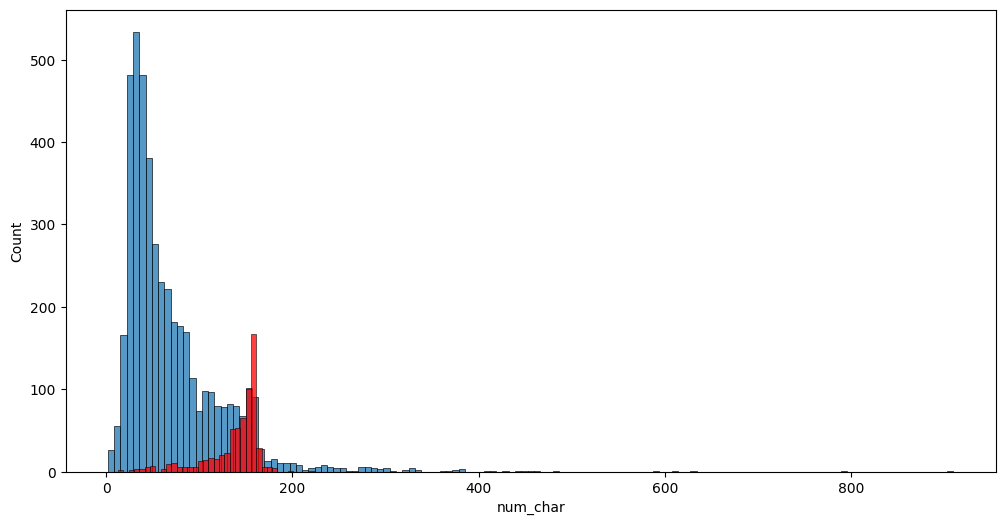

In [71]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_char'])
sns.histplot(df[df['target'] == 1]['num_char'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

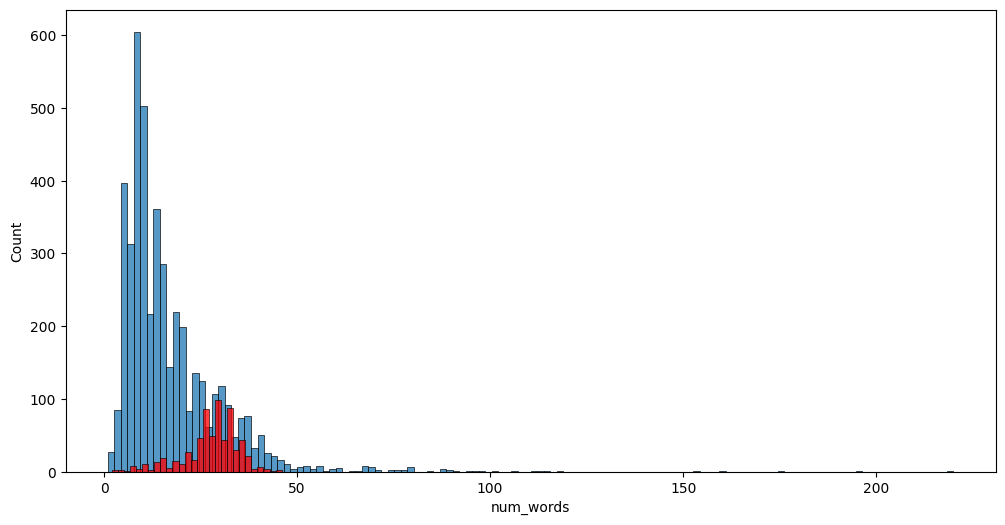

In [72]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'],color='red')

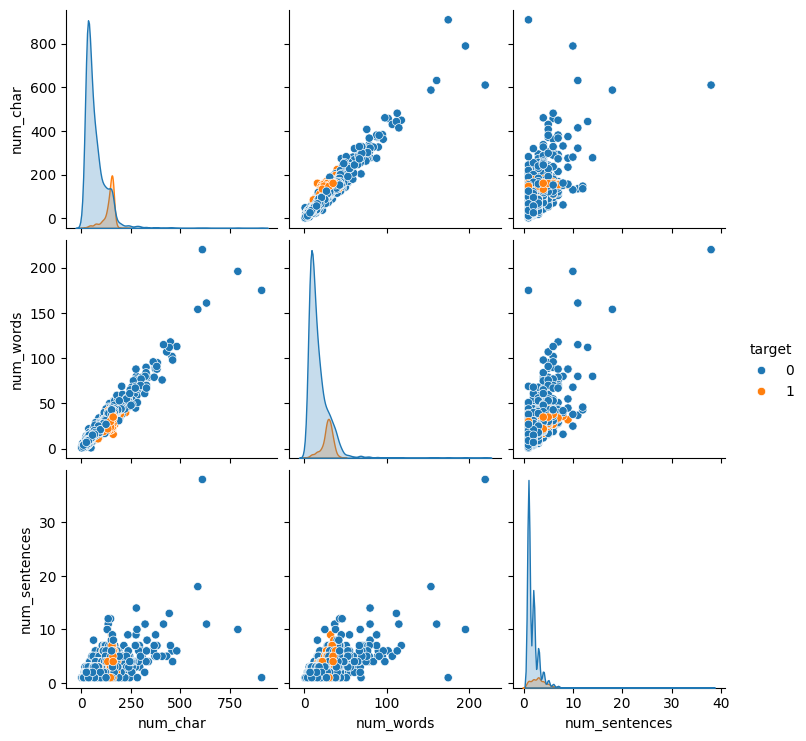

In [73]:
sns.pairplot(df,hue='target')

<Axes: >

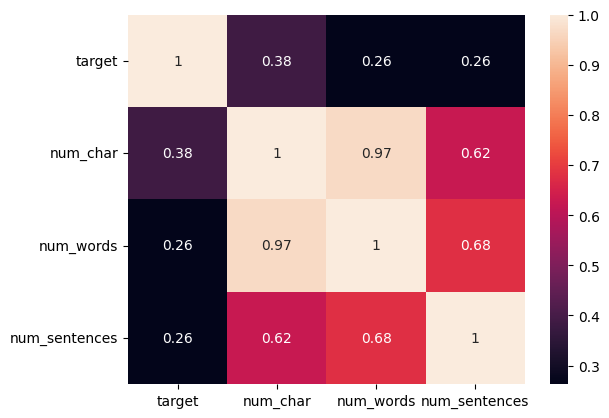

In [74]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

In [75]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)
    
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    
    text = y[:]
    y.clear()
    
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
            
    text = y[:]
    y.clear()
    
    for i in text:
        y.append(ps.stem(i))
    
            
    return " ".join(y)

In [76]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [77]:
df['text'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [78]:
df['transformed_text'] = df['text'].apply(transform_text)

In [79]:
df.head()

,target,text,num_char,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [80]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

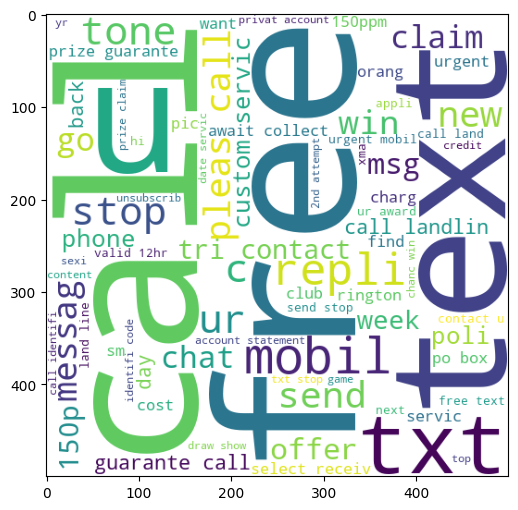

In [81]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

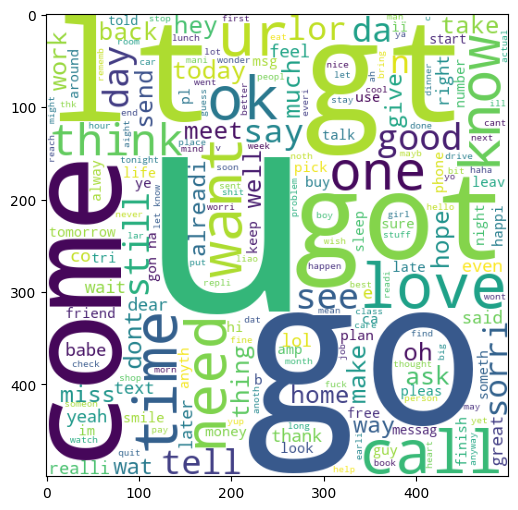

In [82]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [83]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

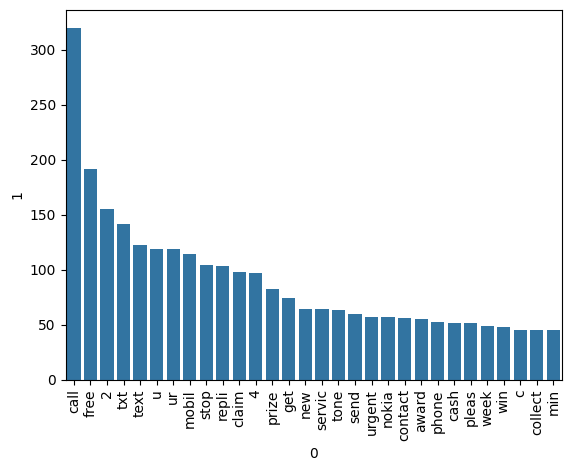

In [84]:
# Create the dataframe just once to keep it clean
common_words = pd.DataFrame(Counter(spam_corpus).most_common(30))

# Pass x and y as specific keywords
sns.barplot(x=common_words[0], y=common_words[1])
plt.xticks(rotation='vertical')
plt.show()

In [85]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

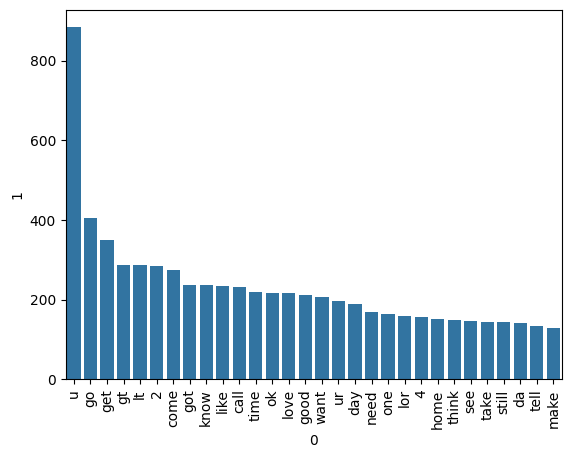

In [86]:
# Create the dataframe first to make it cleaner
ham_common_df = pd.DataFrame(Counter(ham_corpus).most_common(30))

# Use 'x=' and 'y=' explicitly
sns.barplot(x=ham_common_df[0], y=ham_common_df[1])
plt.xticks(rotation='vertical')
plt.show()

In [87]:
cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=5000)

In [88]:
X = tfidf.fit_transform(df['transformed_text']).toarray()


In [89]:
X.shape

(5169, 5000)

In [90]:
y = df['target'].values

In [91]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

In [92]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [93]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred1))
print(confusion_matrix(y_test,y_pred1))
print(precision_score(y_test,y_pred1))

0.8762088974854932
[[793 103]
 [ 25 113]]
0.5231481481481481


In [94]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test,y_pred2))
print(confusion_matrix(y_test,y_pred2))
print(precision_score(y_test,y_pred2))

0.9622823984526112
[[896   0]
 [ 39  99]]
1.0


In [95]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)
print(accuracy_score(y_test,y_pred3))
print(confusion_matrix(y_test,y_pred3))
print(precision_score(y_test,y_pred3))

0.9777562862669246
[[895   1]
 [ 22 116]]
0.9914529914529915


In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

In [97]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [98]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

In [99]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

In [100]:
train_classifier(svc,X_train,y_train,X_test,y_test)

(0.9748549323017408, 0.9745762711864406)

In [101]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9748549323017408
Precision -  0.9745762711864406
For  KN
Accuracy -  0.902321083172147
Precision -  1.0
For  NB
Accuracy -  0.9622823984526112
Precision -  1.0
For  DT
Accuracy -  0.9361702127659575
Precision -  0.8529411764705882
For  LR
Accuracy -  0.9526112185686654
Precision -  0.9494949494949495


/Users/hardikmittal/Documents/MLProject/spam/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/Users/hardikmittal/Documents/MLProject/spam/venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


For  RF
Accuracy -  0.9700193423597679
Precision -  0.9908256880733946
For  AdaBoost
Accuracy -  0.9235976789168279
Precision -  0.8390804597701149
For  BgC
Accuracy -  0.9584139264990329
Precision -  0.8682170542635659
For  ETC
Accuracy -  0.9787234042553191
Precision -  0.9754098360655737
For  GBDT
Accuracy -  0.9526112185686654
Precision -  0.908256880733945
For  xgb
Accuracy -  0.971953578336557
Precision -  0.957983193277311


In [102]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [103]:
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.902321,1.000000
2,NB,0.962282,1.000000
5,RF,0.970019,0.990826
8,ETC,0.978723,0.975410
0,SVC,0.974855,0.974576
10,xgb,0.971954,0.957983
4,LR,0.952611,0.949495
9,GBDT,0.952611,0.908257
7,BgC,0.958414,0.868217
3,DT,0.936170,0.852941


In [104]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")

In [105]:
performance_df1

,Algorithm,variable,value
0,KN,Accuracy,0.902321
1,NB,Accuracy,0.962282
2,RF,Accuracy,0.970019
3,ETC,Accuracy,0.978723
4,SVC,Accuracy,0.974855
5,xgb,Accuracy,0.971954
6,LR,Accuracy,0.952611
7,GBDT,Accuracy,0.952611
8,BgC,Accuracy,0.958414
9,DT,Accuracy,0.936170


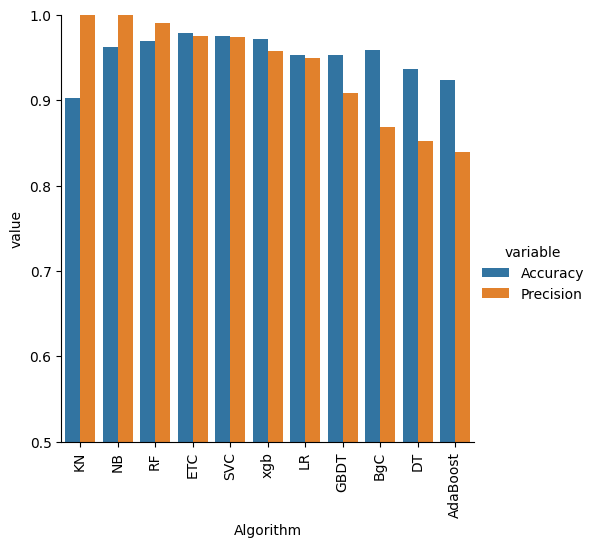

In [106]:
sns.catplot(x = 'Algorithm', y='value', 
               hue = 'variable',data=performance_df1, kind='bar',height=5)
plt.ylim(0.5,1.0)
plt.xticks(rotation='vertical')
plt.show()

In [107]:
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_3000':accuracy_scores,'Precision_max_ft_3000':precision_scores}).sort_values('Precision_max_ft_3000',ascending=False)
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_scores,'Precision_scaling':precision_scores}).sort_values('Precision_scaling',ascending=False)
new_df = performance_df.merge(temp_df,on='Algorithm')
new_df_scaled = new_df.merge(temp_df,on='Algorithm')
temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_scores,'Precision_num_chars':precision_scores}).sort_values('Precision_num_chars',ascending=False)
new_df_scaled.merge(temp_df,on='Algorithm')

,Algorithm,Accuracy,Precision,Accuracy_scaling_x,Precision_scaling_x,Accuracy_scaling_y,Precision_scaling_y,Accuracy_num_chars,Precision_num_chars
0,KN,0.902321,1.000000,0.902321,1.000000,0.902321,1.000000,0.902321,1.000000
1,NB,0.962282,1.000000,0.962282,1.000000,0.962282,1.000000,0.962282,1.000000
2,RF,0.970019,0.990826,0.970019,0.990826,0.970019,0.990826,0.970019,0.990826
3,ETC,0.978723,0.975410,0.978723,0.975410,0.978723,0.975410,0.978723,0.975410
4,SVC,0.974855,0.974576,0.974855,0.974576,0.974855,0.974576,0.974855,0.974576
5,xgb,0.971954,0.957983,0.971954,0.957983,0.971954,0.957983,0.971954,0.957983
6,LR,0.952611,0.949495,0.952611,0.949495,0.952611,0.949495,0.952611,0.949495
7,GBDT,0.952611,0.908257,0.952611,0.908257,0.952611,0.908257,0.952611,0.908257
8,BgC,0.958414,0.868217,0.958414,0.868217,0.958414,0.868217,0.958414,0.868217
9,DT,0.936170,0.852941,0.936170,0.852941,0.936170,0.852941,0.936170,0.852941


In [108]:
svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)

In [109]:
voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('et', etc)],voting='soft')
voting.fit(X_train,y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('svm', ...), ('nb', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'sigmoid'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",1.0
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0


In [110]:
y_pred = voting.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9787234042553191
Precision 0.9915254237288136


In [111]:
estimators=[('svm', svc), ('nb', mnb), ('et', etc)]
final_estimator=RandomForestClassifier()

In [112]:
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [113]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Accuracy",accuracy_score(y_test,y_pred))
print("Precision",precision_score(y_test,y_pred))

Accuracy 0.9796905222437138
Precision 0.9465648854961832


In [116]:
import pickle
mnb.fit(X_train, y_train)
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))
print("Success: Model trained and saved!")

Success: Model trained and saved!
